In [2]:
import engine as ng
from pathlib import Path
import pandas as pd
import json
from typing import List, Callable, Dict, Tuple
import networkx as nx
from matplotlib import pyplot as plt
from engine.graph_io import import_graph
import numpy as np

data_path = Path("data")

In [3]:
from engine.ranking import get_recipe_cutoff

def plot_ingredient_info(bipartite_graph: nx.Graph, ingredient_cutoff_percentage=0.9):
    ingredient_with_occurrence = [(len(list(bipartite_graph.neighbors(ingredient))) , ingredient) for ingredient in bipartite_graph.nodes if bipartite_graph.nodes[ingredient]["type"] == "ingredient"]
    ingredient_with_occurrence = sorted(ingredient_with_occurrence)

    # Extract the ingredient names and occurrence values
    occurrences = [x[0] for x in ingredient_with_occurrence]
    ingredients = [i for i,x in enumerate(ingredient_with_occurrence)]

    def plot_row(ingredients, occurrences: list, axs, apply_cutoff=False):
        # Compute the cumulative sum of the occurrence values
        cumulative_occurrences = np.cumsum(occurrences)
        inverse_cumulative_occurrences = np.cumsum(list(reversed(occurrences)))

        cutoff_index = -1
        total = cumulative_occurrences[-1]
        for i, cumsum in enumerate(inverse_cumulative_occurrences):
            if cumsum / total >= ingredient_cutoff_percentage:
                cutoff_index = len(ingredients) - i - 1
                break

        if apply_cutoff:
            ingredients = ingredients[cutoff_index:]
            occurrences = occurrences[cutoff_index:]
            cumulative_occurrences = np.cumsum(occurrences)

        # Plot the histogram
        axs[0].bar(ingredients, occurrences)
        axs[0].set_xlabel('Ingredients')
        axs[0].set_ylabel('Occurrence')
        axs[0].set_title('Ingredient Occurrence Histogram' if not apply_cutoff else f"Cutoff at {ingredient_cutoff_percentage * 100}%")

        axs[1].boxplot(occurrences)
        axs[1].set_xlabel('Data')
        axs[1].set_ylabel('Ingredient Occurrence')
        axs[1].set_title('Boxplot of Ingredient Occurrence' if not apply_cutoff else f"Cutoff at {ingredient_cutoff_percentage * 100}%")

        # Plot the cumulative occurrence
        axs[2].plot(ingredients, cumulative_occurrences)
        if cutoff_index != -1 and not apply_cutoff:
            axs[2].plot([ingredients[cutoff_index], ingredients[cutoff_index]], [0, cumulative_occurrences[-1]], cumulative_occurrences)
        axs[2].set_xlabel('Ingredients')
        axs[2].set_ylabel('Cumulative Occurrence')
        axs[2].set_title('Cumulative Occurrence of Ingredients' if not apply_cutoff else f"Cutoff at {ingredient_cutoff_percentage * 100}%")

    # Create a 2x3 grid of subplots
    fig, axs = plt.subplots(2, 3)
    plot_row(ingredients, occurrences, axs[0])
    plot_row(ingredients, occurrences, axs[1], apply_cutoff=True)

    # Adjust the layout of the subplots
    plt.tight_layout()
    # Set the size of the figure
    fig.set_size_inches(10, 6)
    fig.suptitle('Ingredient Info')

    plt.plot()

def plot_recipe_info(bipartite_graph: nx.Graph, recipe_cutoff_percentage=0.9, batch_size=100, recipe_importance=None):
    if recipe_importance is None:
        recipe_importance = get_recipe_cutoff(bipartite_graph, recipe_cutoff_percentage=1)

    # Extract the ingredient names and occurrence values
    importance = [x[0] for x in recipe_importance]
    recipes = [i for i,x in enumerate(recipe_importance)]

    def plot_row(recipes, importance: list, axs, apply_cutoff=False):

        indexes = [i for i in range(0, len(recipes), batch_size)]
        importance = [np.mean(importance[i: i+batch_size]) for i in indexes]
        importance.reverse()
        recipes = [i for i in range(len(indexes))]

        # Compute the cumulative sum of the importance values
        cumulative_importance = np.cumsum(importance)
        inverse_cumulative_occurrences = np.cumsum(list(reversed(importance)))

        cutoff_index = -1
        total = cumulative_importance[-1]
        for i, cumsum in enumerate(inverse_cumulative_occurrences):
            if cumsum / total >= recipe_cutoff_percentage:
                cutoff_index = len(recipes) - i - 1
                break

        if apply_cutoff:
            recipes = recipes[cutoff_index:]
            importance = importance[cutoff_index:]
            cumulative_importance = np.cumsum(importance)

        # Plot the histogram
        axs[0].bar(recipes, importance)
        axs[0].set_xlabel('Recipes')
        axs[0].set_ylabel('Importance')
        axs[0].set_title('Recipe Importance Histogram' if not apply_cutoff else f"Cutoff at {recipe_cutoff_percentage * 100}%")

        axs[1].boxplot(importance)
        axs[1].set_xlabel('Data')
        axs[1].set_ylabel('Recipe Importance')
        axs[1].set_title('Boxplot of Recipe Importance' if not apply_cutoff else f"Cutoff at {recipe_cutoff_percentage * 100}%")

        # Plot the cumulative occurrence
        axs[2].plot(recipes, cumulative_importance)
        if cutoff_index != -1 and not apply_cutoff:
            axs[2].plot([recipes[cutoff_index], recipes[cutoff_index]], [0, cumulative_importance[-1]], cumulative_importance)
        axs[2].set_xlabel('Recipes')
        axs[2].set_ylabel('Cumulative Importance')
        axs[2].set_title('Cumulative Importance of Recipes' if not apply_cutoff else f"Cutoff at {recipe_cutoff_percentage * 100}%")
        return indexes[cutoff_index]

    # Create a 2x3 grid of subplots
    fig, axs = plt.subplots(3, 3)
    plot_row(recipes, importance, axs[0])
    cutoff = plot_row(recipes, importance, axs[1], apply_cutoff=True)

    scatter_ax = axs[2][0]
    scatter_ax.scatter([len(list(bipartite_graph.neighbors(x))) for _, x in recipe_importance[:cutoff]], [x for x, _ in recipe_importance[:cutoff]])
    scatter_ax.set_xlabel("Node Degree")
    scatter_ax.set_ylabel("Recipe Importance")
    scatter_ax.set_title("Inside Cutoff Recipes")

    scatter_ax = axs[2][1]
    scatter_ax.scatter([len(list(bipartite_graph.neighbors(x))) for _, x in recipe_importance[:cutoff]], [x for x, _ in recipe_importance[:cutoff]])
    scatter_ax.scatter([len(list(bipartite_graph.neighbors(x))) for _, x in recipe_importance[cutoff:]], [x for x, _ in recipe_importance[cutoff:]])
    scatter_ax.set_xlabel("Node Degree")
    scatter_ax.set_ylabel("Recipe Importance")
    scatter_ax.set_title("Both Cutoff Recipes")

    scatter_ax = axs[2][2]
    scatter_ax.scatter([len(list(bipartite_graph.neighbors(x))) for _, x in recipe_importance[cutoff:]], [x for x, _ in recipe_importance[cutoff:]])
    scatter_ax.set_xlabel("Node Degree")
    scatter_ax.set_ylabel("Recipe Importance")
    scatter_ax.set_title("Outside Cutoff Recipes")

    # Adjust the layout of the subplots
    plt.tight_layout()
    # Set the size of the figure
    fig.set_size_inches(10, 10)
    fig.suptitle(f'Recipe Info: Batch Size {batch_size}')

    plt.plot()


# Foodcom

In [3]:
bipartite_graph = import_graph(data_path / "graphs" / "foodcom" / "bipartite_recipe_ingredient.graphml")

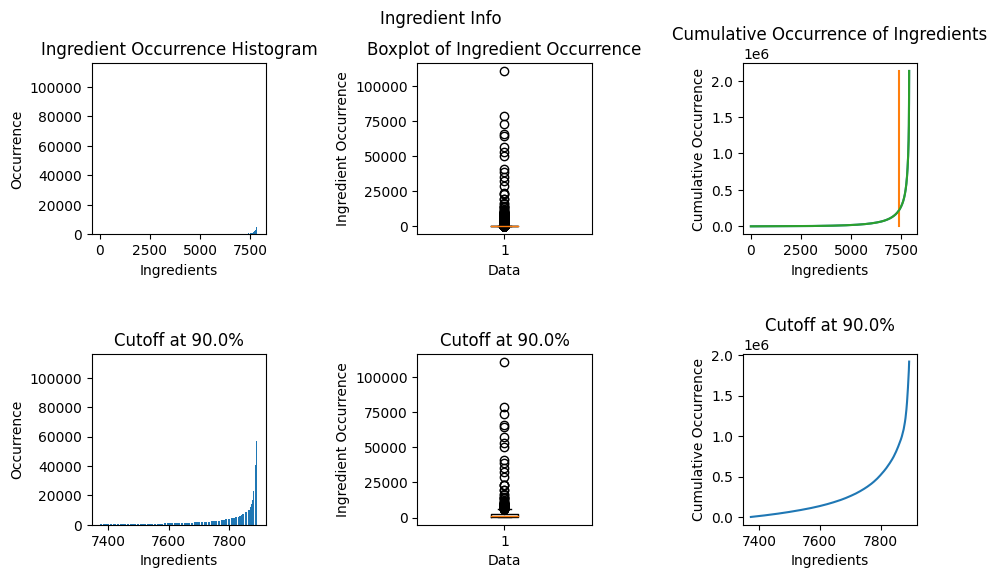

In [8]:
plot_ingredient_info(bipartite_graph)

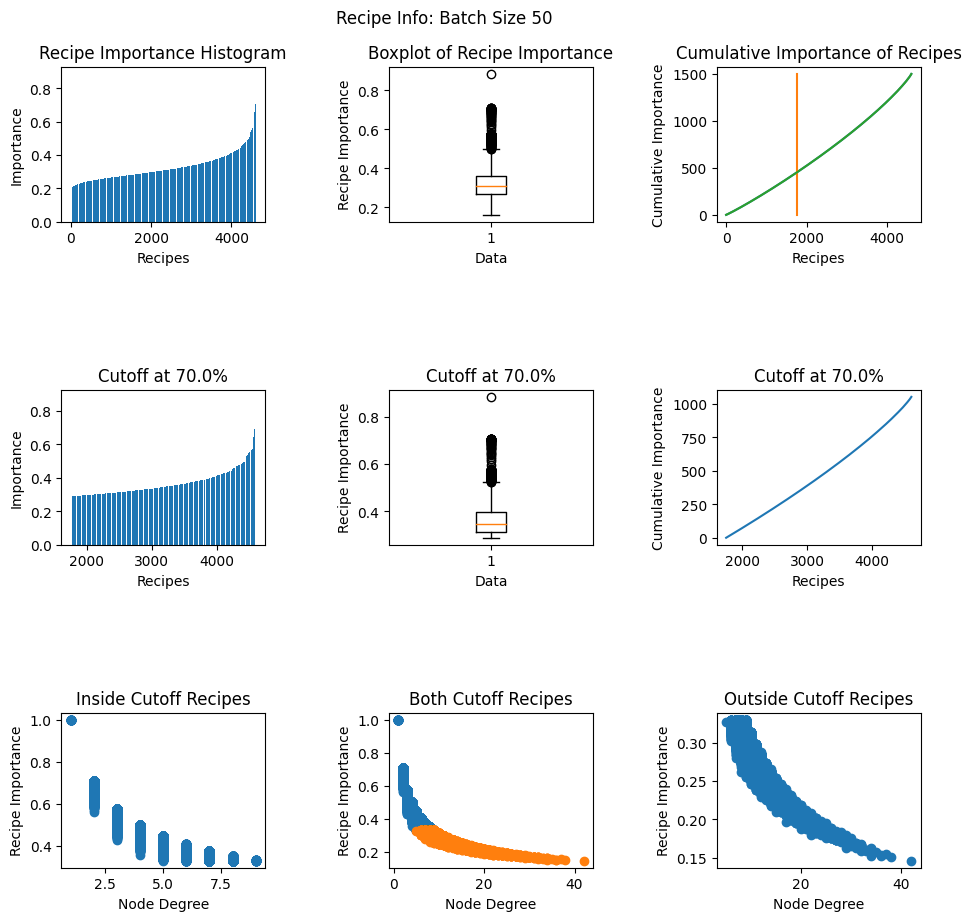

In [9]:
from engine.ranking import get_recipe_cutoff
recipe_importance = get_recipe_cutoff(bipartite_graph, recipe_cutoff_percentage=1)

plot_recipe_info(bipartite_graph, recipe_cutoff_percentage=0.7, batch_size=50, recipe_importance=recipe_importance)

In [4]:
foodcom_recipes_norm_path = data_path / "graphs" / "foodcom" / "food.com.recipe_normalized.json"
foodcom_recipes_json = json.load(foodcom_recipes_norm_path.open())

In [5]:
from engine.ranking import get_recipe_ranking
recipe_ranking = get_recipe_ranking(foodcom_recipes_json)

Max amount: 1601
Max rating: 5.0
Receta: to die for crock pot roast Rating: 4.288569643972517 Cantidad: 1601 Valor 0.9234079752538497
Receta: crock pot chicken with black beans   cream cheese Rating: 4.220392653578214 Cantidad: 1579 Valor 0.9096463066843959
Receta: creamy cajun chicken pasta Rating: 4.541436464088398 Cantidad: 1448 Valor 0.9063569166429973
Receta: best ever banana cake with cream cheese frosting Rating: 4.329046898638427 Cantidad: 1322 Valor 0.8452969209499187
Receta: yes  virginia there is a great meatloaf Rating: 4.213793103448276 Cantidad: 1305 Valor 0.8287066291957329
Receta: whatever floats your boat  brownies Rating: 4.525409836065574 Cantidad: 1220 Valor 0.827414770764249
Receta: jo mama s world famous spaghetti Rating: 4.423014586709886 Cantidad: 1234 Valor 0.8237715690239957
Receta: kittencal s italian melt in your mouth meatballs Rating: 4.708124373119358 Cantidad: 997 Valor 0.7496781573677314
Receta: japanese mum s chicken Rating: 4.398230088495575 Cantidad:

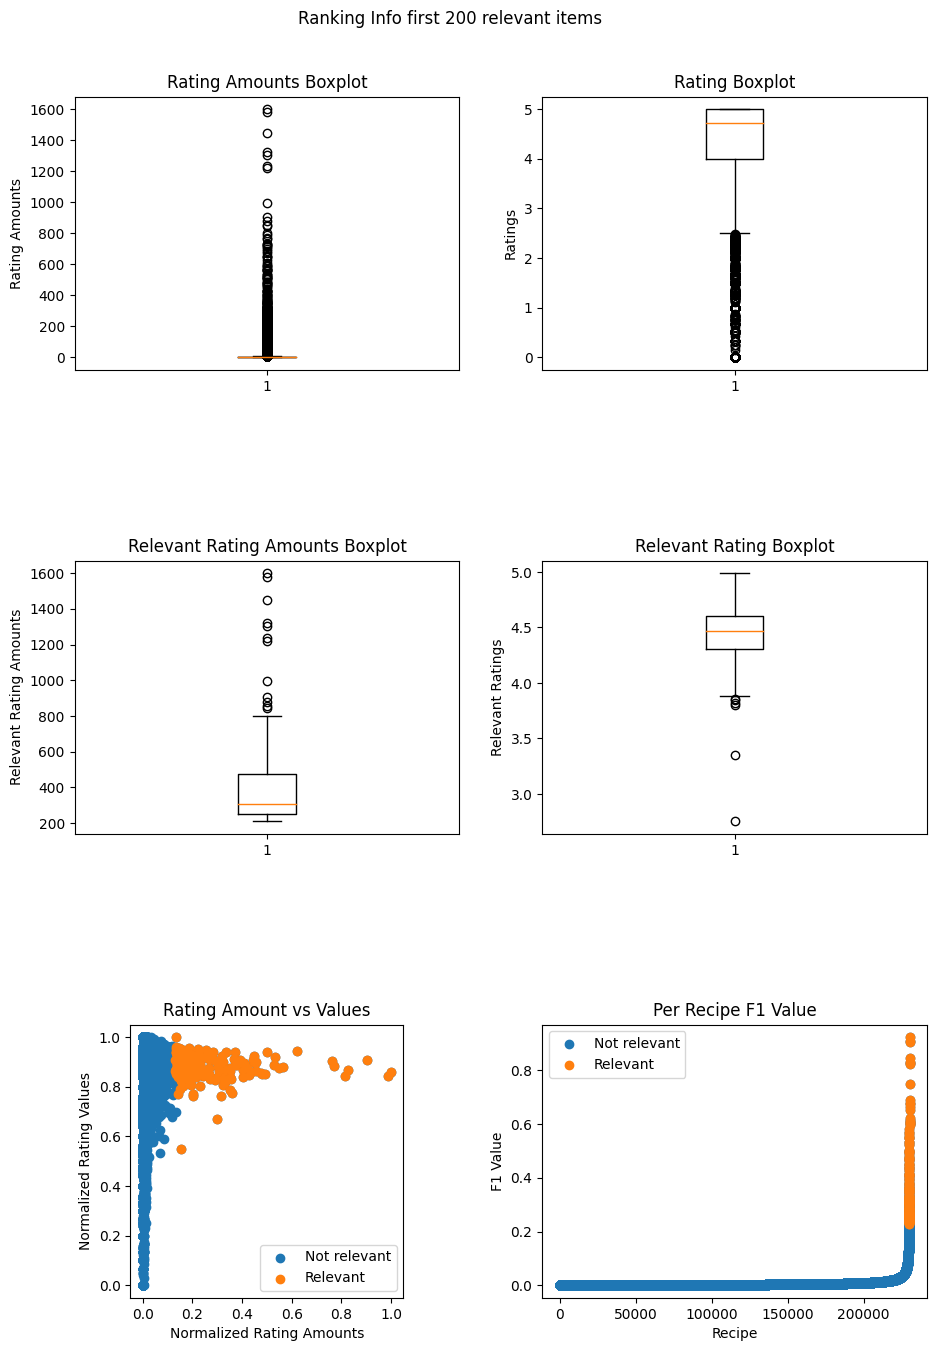

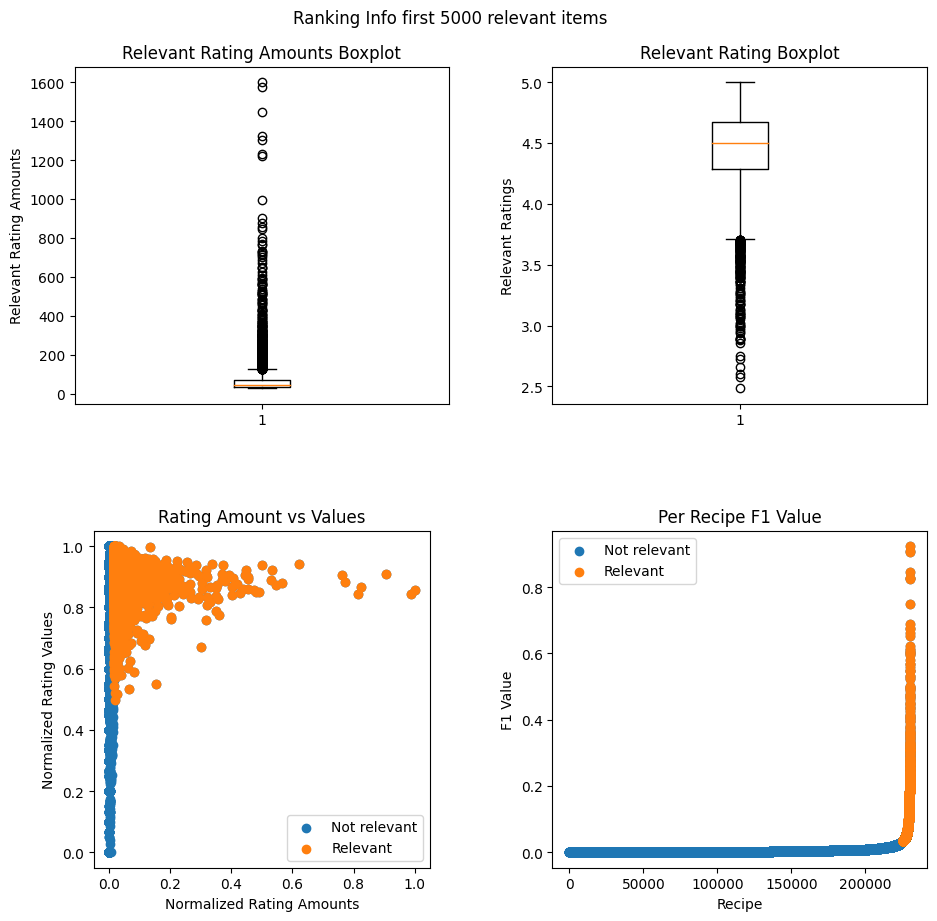

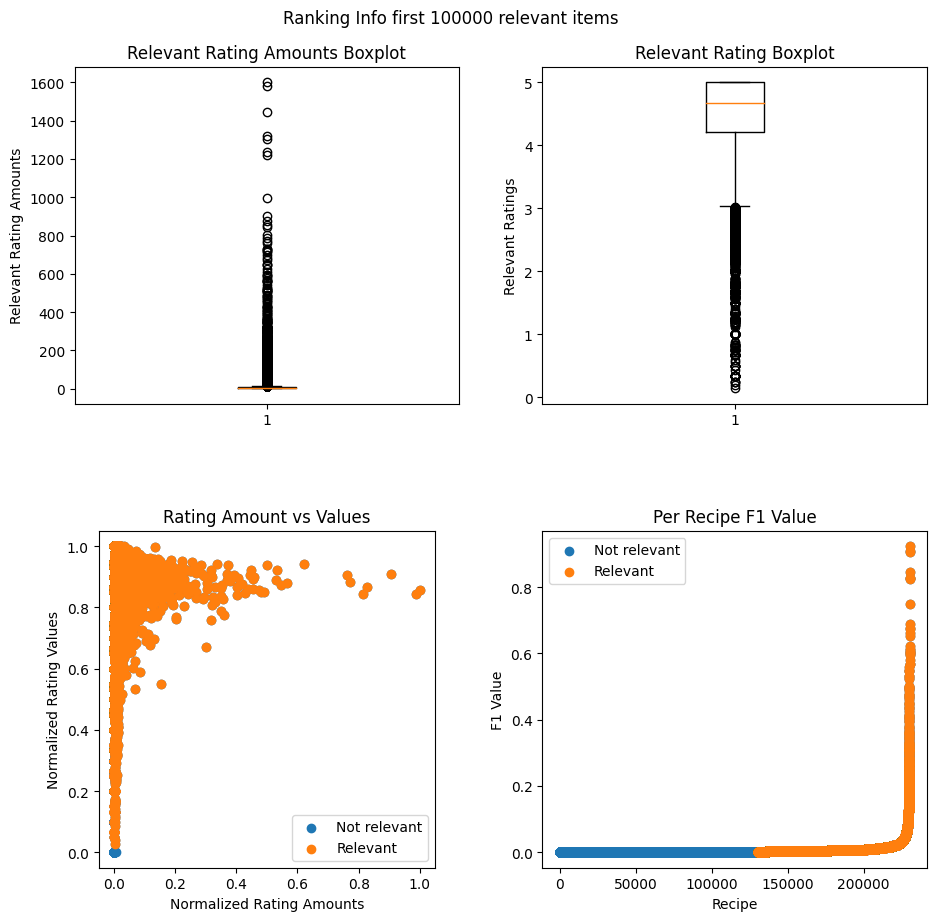

In [11]:

amounts = [foodcom_recipes_json[x]["cantidad_comentarios"] for x in foodcom_recipes_json]
ratings = [foodcom_recipes_json[x]["rating"] for x in foodcom_recipes_json]

def plot_rating_info(amounts: list[float], ratings: list[float], ranked_recipes: list[str], json_recipe: dict, trailing_tag: str, print_extra=False):
    
    max_amount = max(amounts)
    max_rating = max(ratings)

    if print_extra:
        print("Max amount:", max_amount)
        print("Max rating:", max_rating)

    if print_extra:
        for val, recipe in recipe_ranking[:10]:
            rating, amount = foodcom_recipes_json[recipe]["rating"], foodcom_recipes_json[recipe]["cantidad_comentarios"]
            print("Receta:", recipe, "Rating:", rating, "Cantidad:", amount, "Valor", val)

    norm_amounts = [x / max_amount for x in amounts]
    norm_ratings = [x / max_rating for x in ratings]
    norm_amount_ranked = [json_recipe[x]["cantidad_comentarios"] / max_amount for x in ranked_recipes]
    norm_rating_ranked = [json_recipe[x]["rating"] / max_rating for x in ranked_recipes]

    def f1(a, b):
        return 2 * (a * b) / (a + b)
    
    f1_all = sorted([f1(x,y) for x,y in zip(norm_amounts, norm_ratings)])
    f1_ranked = sorted([f1(x,y) for x,y in zip(norm_amount_ranked, norm_rating_ranked)])

    # Create a grid of subplots
    if print_extra:
        fig, axs = plt.subplots(3, 2)
        scatter_ax = axs[0][0]
        scatter_ax.boxplot(amounts)
        scatter_ax.set_ylabel("Rating Amounts")
        scatter_ax.set_title("Rating Amounts Boxplot")

        scatter_ax = axs[0][1]
        scatter_ax.boxplot(ratings)
        scatter_ax.set_ylabel("Ratings")
        scatter_ax.set_title("Rating Boxplot")

        axs = axs[1:]
    else:
        fig, axs = plt.subplots(2, 2)

    scatter_ax = axs[0][0]
    scatter_ax.boxplot([foodcom_recipes_json[recipe]["cantidad_comentarios"] for recipe in ranked_recipes])
    scatter_ax.set_ylabel("Relevant Rating Amounts")
    scatter_ax.set_title("Relevant Rating Amounts Boxplot")

    scatter_ax = axs[0][1]
    scatter_ax.boxplot([foodcom_recipes_json[recipe]["rating"] for recipe in ranked_recipes])
    scatter_ax.set_ylabel("Relevant Ratings")
    scatter_ax.set_title("Relevant Rating Boxplot")

    scatter_ax = axs[1][0]
    scatter_ax.scatter(norm_amounts, norm_ratings, label="Not relevant")
    scatter_ax.scatter(norm_amount_ranked, norm_rating_ranked, label="Relevant")
    scatter_ax.set_aspect('equal')
    scatter_ax.legend()
    scatter_ax.set_xlabel("Normalized Rating Amounts")
    scatter_ax.set_ylabel("Normalized Rating Values")
    scatter_ax.set_title("Rating Amount vs Values")

    scatter_ax = axs[1][1]
    scatter_ax.scatter([i for i in range(len(f1_all))], f1_all, label="Not relevant")
    scatter_ax.scatter([i for i in range(len(f1_all) - len(f1_ranked), len(f1_all))], f1_ranked, label="Relevant")
    scatter_ax.legend()
    scatter_ax.set_xlabel("Recipe")
    scatter_ax.set_ylabel("F1 Value")
    scatter_ax.set_title("Per Recipe F1 Value")

    # Adjust the layout of the subplots
    plt.tight_layout()
    # Set the size of the figure
    if print_extra:
        fig.set_size_inches(10, 15)
    else:
        fig.set_size_inches(10, 10)
    fig.suptitle(f'Ranking Info {trailing_tag}')

    plt.plot()

plot_rating_info(amounts, ratings, [x[1] for x in recipe_ranking[:200]], foodcom_recipes_json, trailing_tag="first 200 relevant items", print_extra=True)
plot_rating_info(amounts, ratings, [x[1] for x in recipe_ranking[:5000]], foodcom_recipes_json, trailing_tag="first 5000 relevant items")
plot_rating_info(amounts, ratings, [x[1] for x in recipe_ranking[:100000]], foodcom_recipes_json, trailing_tag="first 100000 relevant items")


In [3]:
from engine.graph_io import import_graph
from engine.ranking import get_edge_similarity_vector_ranking, exponential_similarity

# Reduced Graph
take_first = 5000
graph_base_path = data_path / "graphs" / "foodcom"
B = import_graph(graph_base_path / f"bipartite_recipe_ingredient_reduced_{take_first}.graphml")
assert nx.is_bipartite(B)

foodcom_semantic_dict = {}
for v in (data_path / "foodcom.sematic").iterdir():
    foodcom_semantic_dict = {
        **foodcom_semantic_dict,
        **np.load(v)
    }
print(len(foodcom_semantic_dict))

l = [x for x in foodcom_semantic_dict.keys()]
print("Vector amount:", len(l))
r = [x.removesuffix("_recipe") for x in B.nodes if x.endswith("_recipe")]

print("Relevant Example:", r[0])
print("Relevant amount:", len(r))
print("Relevant Intersection:", len(set(l).intersection(r)))
l_relevant = list(set(l).intersection(r))

230185
Vector amount: 230185
Relevant Example: how i got my family to eat spinach  spinach casserole
Relevant amount: 5000
Relevant Intersection: 5000


In [4]:
edge_ranking = get_edge_similarity_vector_ranking({x: foodcom_semantic_dict[x] for x in l_relevant}, exponential_similarity)
print(len(edge_ranking))

12497500


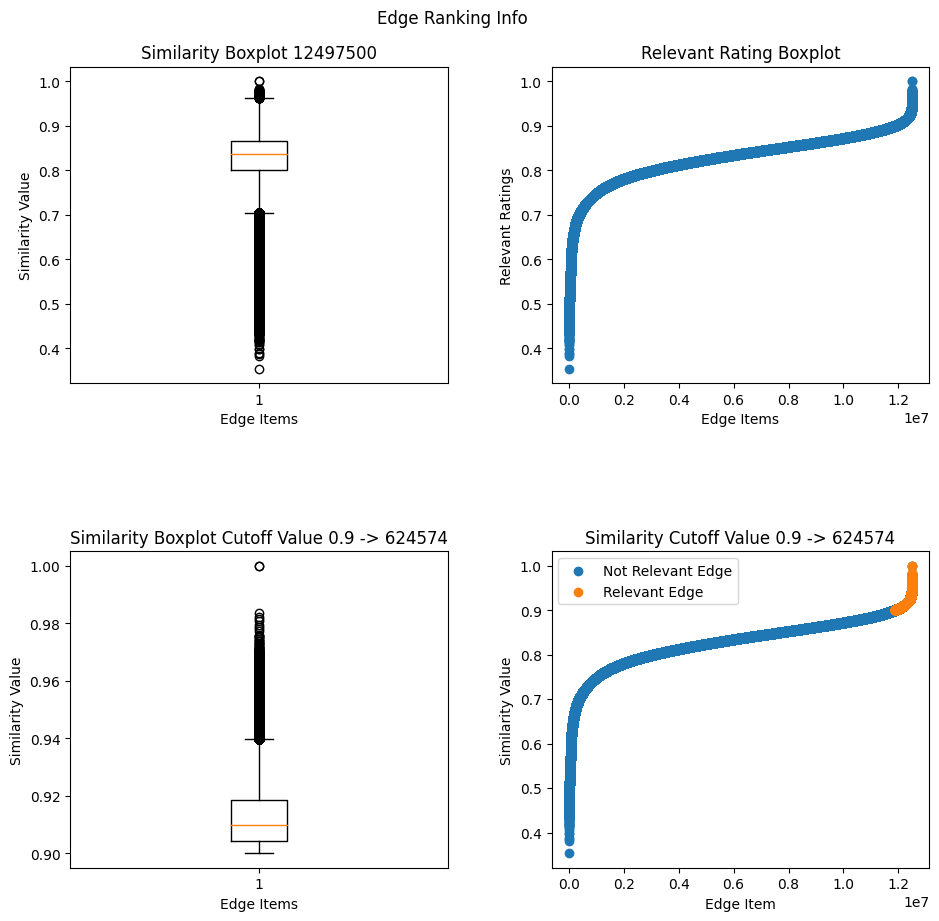

In [6]:

def plot_edge_ranking_info(edge_ranking: list[(float, str, str)], cutoff_sim=0.9):
    fig, axs = plt.subplots(2, 2)

    rankings = [s for s,x,y in edge_ranking]
    rankings.reverse()

    scatter_ax = axs[0][0]
    scatter_ax.boxplot(rankings)
    scatter_ax.set_ylabel("Similarity Value")
    scatter_ax.set_xlabel("Edge Items")
    scatter_ax.set_title(f"Similarity Boxplot {len(rankings)}")

    scatter_ax = axs[0][1]
    scatter_ax.scatter([i for i in range(len(rankings))], rankings)
    scatter_ax.set_ylabel("Relevant Ratings")
    scatter_ax.set_xlabel("Edge Items")
    scatter_ax.set_title("Relevant Rating Boxplot")

    cutoff_rankings = [s for s in rankings if s >= cutoff_sim]
    difference = len(rankings) - len(cutoff_rankings)

    scatter_ax = axs[1][0]
    scatter_ax.boxplot(cutoff_rankings)
    scatter_ax.set_ylabel("Similarity Value")
    scatter_ax.set_xlabel("Edge Items")
    scatter_ax.set_title(f"Similarity Boxplot Cutoff Value {cutoff_sim} -> {len(cutoff_rankings)}")

    scatter_ax = axs[1][1]
    scatter_ax.scatter([i for i in range(len(rankings))], rankings, label="Not Relevant Edge")
    scatter_ax.scatter([i for i in range(difference, len(rankings))], cutoff_rankings, label="Relevant Edge")
    scatter_ax.legend()
    scatter_ax.set_ylabel("Similarity Value")
    scatter_ax.set_xlabel("Edge Item")
    scatter_ax.set_title(f"Similarity Cutoff Value {cutoff_sim} -> {len(cutoff_rankings)}")

    # Adjust the layout of the subplots
    plt.tight_layout()
    # Set the size of the figure
    fig.set_size_inches(10, 10)
    fig.suptitle(f'Edge Ranking Info')

    plt.plot()

plot_edge_ranking_info(edge_ranking)

### Semantic training

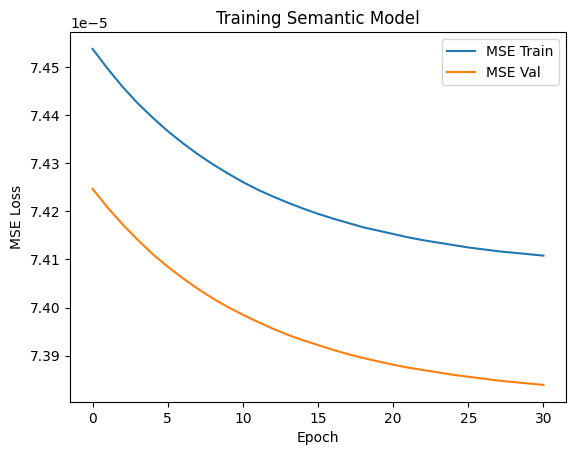

In [3]:
import json
from pathlib import Path
import matplotlib.pyplot as plt

json_data_path = Path("data", "real_training_history.json")

json_data = json.loads(json_data_path.read_text())

X = [i for i in range(len(json_data['loss']))]
plt.plot(X, json_data['loss'], label="MSE Train")
plt.plot(X, json_data['val_loss'], label="MSE Val")
plt.plot(X, json_data['val_loss'], label="MSE Val")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Semantic Model")
plt.show()

# RecipeNLG

In [3]:
bipartite_graph = import_graph(data_path / "graphs" / "recipenlg" / "bipartite_recipe_ingredient.graphml")

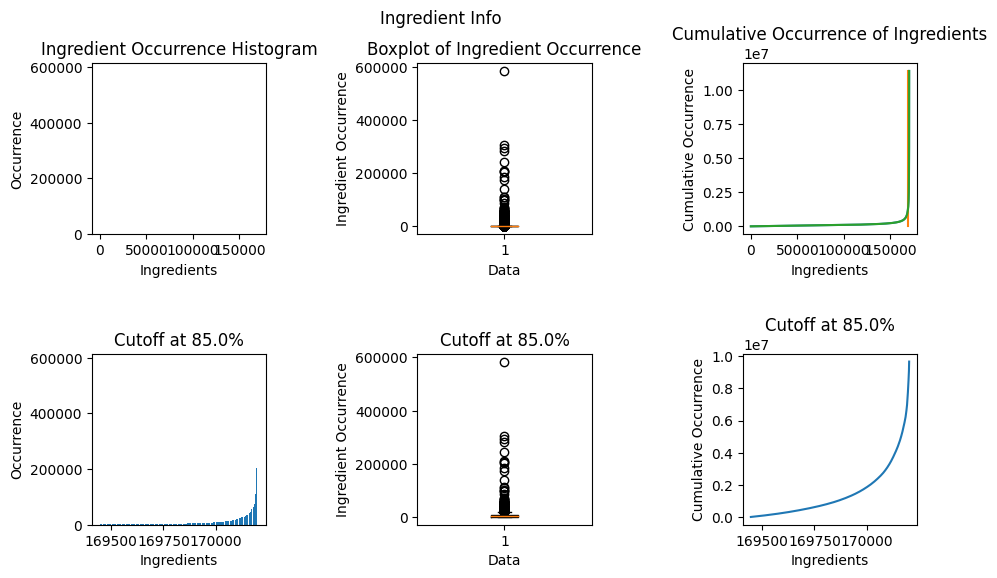

In [4]:
plot_ingredient_info(bipartite_graph, ingredient_cutoff_percentage=0.85)

c:\Users\Luis\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


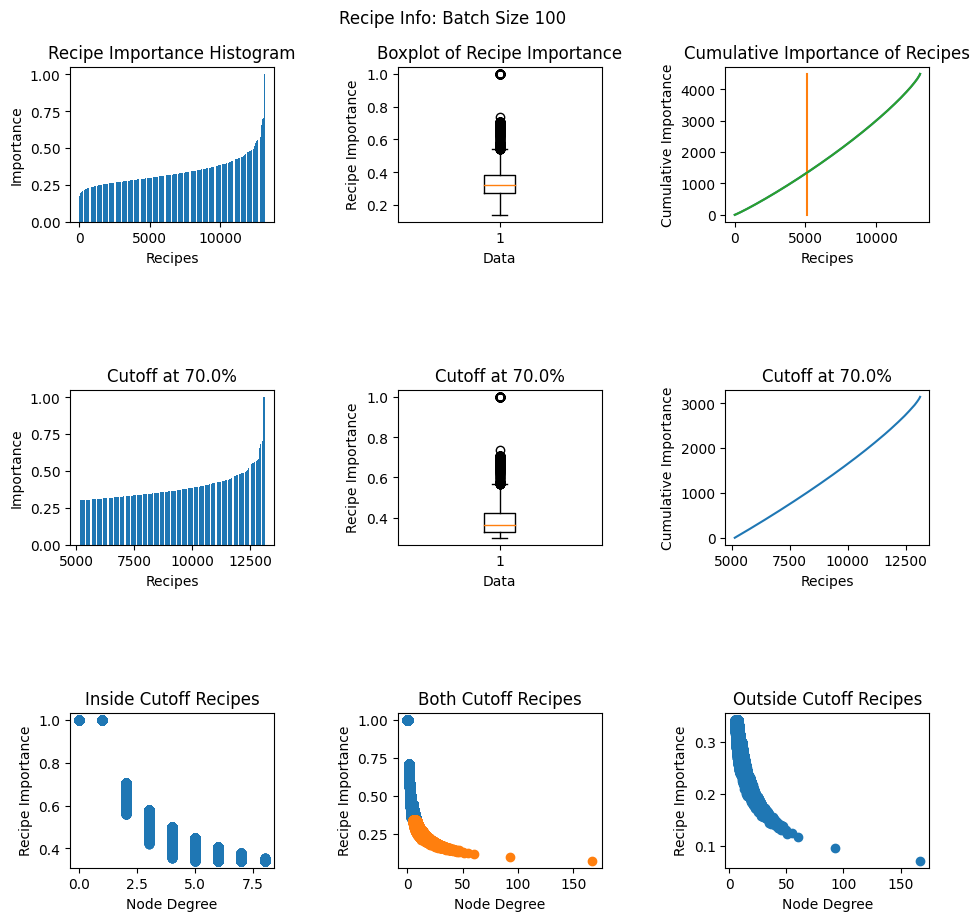

In [4]:
from engine.ranking import get_recipe_cutoff
recipe_importance = get_recipe_cutoff(bipartite_graph, recipe_cutoff_percentage=1)

plot_recipe_info(bipartite_graph, recipe_cutoff_percentage=0.7, batch_size=100, recipe_importance=recipe_importance)